In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE  # For handling class imbalance

In [2]:
# Load dataset
data = pd.read_csv('winequality-red.csv', sep=";")

In [3]:
# Data Exploration
print("\nDataset Head:\n", data.head())
print("\nDataset Info:\n")
data.info()
print("\nStatistical Summary:\n", data.describe())


Dataset Head:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2   

In [4]:
# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())


Missing Values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


C:\Users\Mayank\AppData\Local\Temp\ipykernel_9424\597036605.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=data, palette='muted')


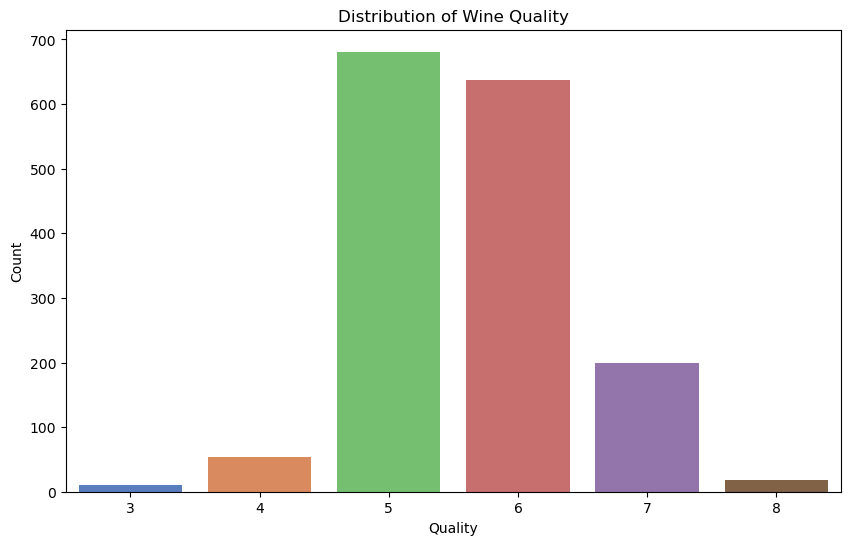

In [5]:
# Data Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=data, palette='muted')
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

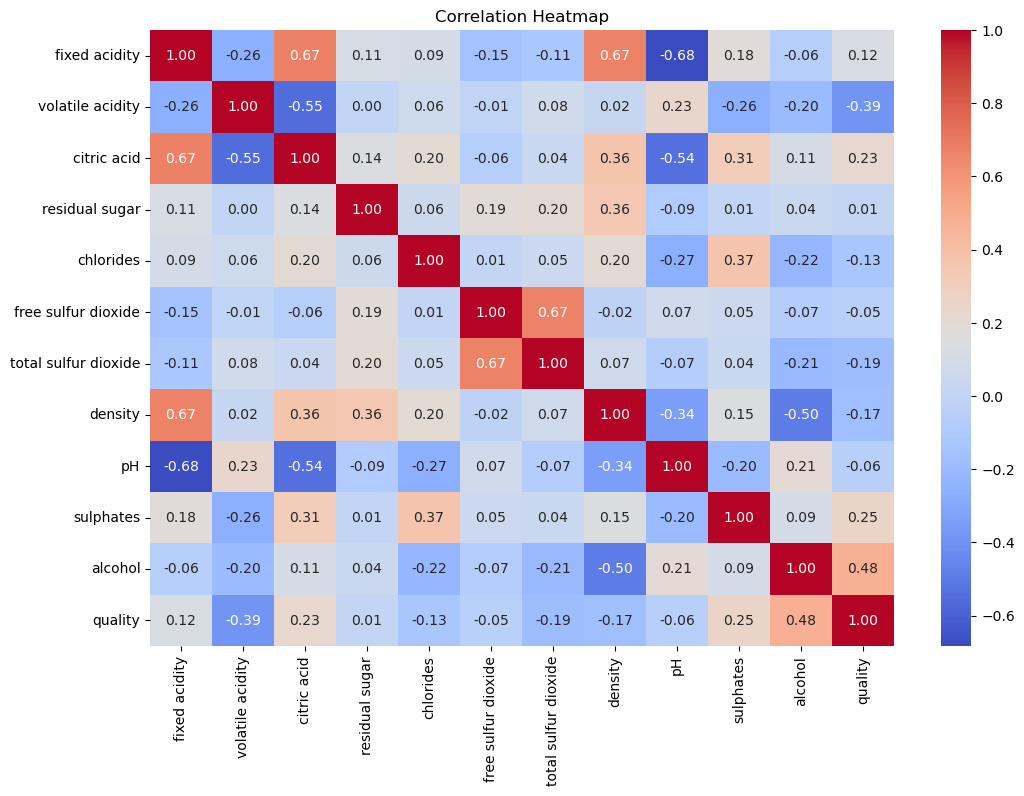

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

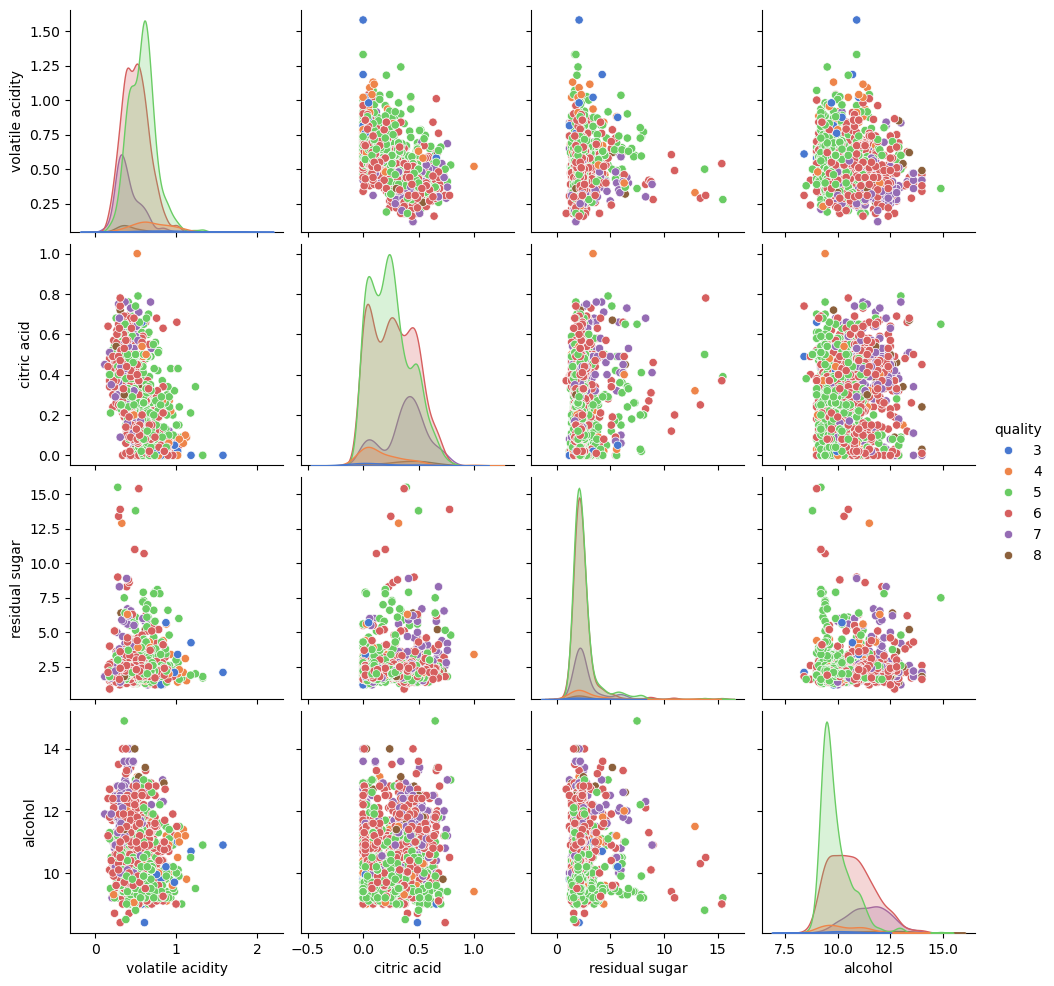

In [7]:
# Pairplot for selected features
selected_features = ['volatile acidity', 'citric acid', 'residual sugar', 'alcohol', 'quality']
sns.pairplot(data[selected_features], hue='quality', palette='muted')
plt.show()

In [8]:
# Preprocessing
X = data.drop('quality', axis=1)
y = data['quality']

In [9]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

In [12]:
# Base models with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)

In [13]:
# Create a stacking ensemble
estimators = [('rf', rf), ('gb', gb), ('svc', svc)]
stacking_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier(random_state=42)
)

In [14]:
# Hyperparameter tuning for the stacking model
param_grid = {
    'final_estimator__n_estimators': [50, 100],
    'final_estimator__learning_rate': [0.01, 0.1],
    'final_estimator__max_depth': [3, 5],
}
grid_search = GridSearchCV(stacking_clf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('rf',
                                                       RandomForestClassifier(class_weight='balanced',
                                                                              random_state=42)),
                                                      ('gb',
                                                       GradientBoostingClassifier(random_state=42)),
                                                      ('svc',
                                                       SVC(class_weight='balanced',
                                                           probability=True,
                                                           random_state=42))],
                                          final_estimator=GradientBoostingClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'final_estimator__learning_rate': [0.01, 0.1],
                         'final_estimator__max_depth': [3, 5],
                         'final_estimator__n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [15]:
# Best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:\n", grid_search.best_params_)


Best Parameters:
 {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 100}


In [16]:
# Training and Prediction
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test).max(axis=1)

In [17]:
# Evaluation
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8499184339314845

Classification Report:
               precision    recall  f1-score   support

           3       0.99      1.00      0.99       200
           4       0.88      0.93      0.91       197
           5       0.70      0.75      0.73       218
           6       0.72      0.56      0.63       220
           7       0.83      0.90      0.87       188
           8       0.99      0.99      0.99       203

    accuracy                           0.85      1226
   macro avg       0.85      0.86      0.85      1226
weighted avg       0.85      0.85      0.85      1226



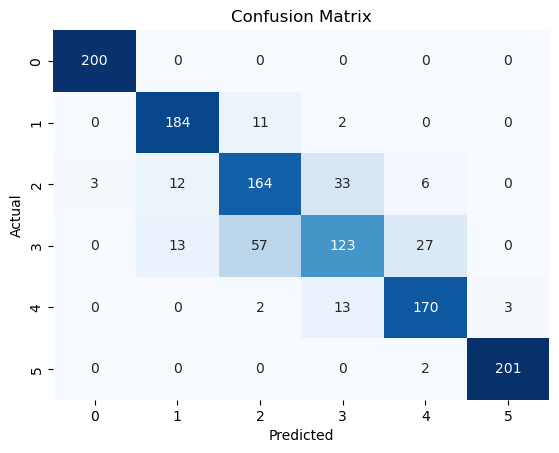

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\Mayank\AppData\Local\Temp\ipykernel_9424\754055572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=X.columns, palette='muted')


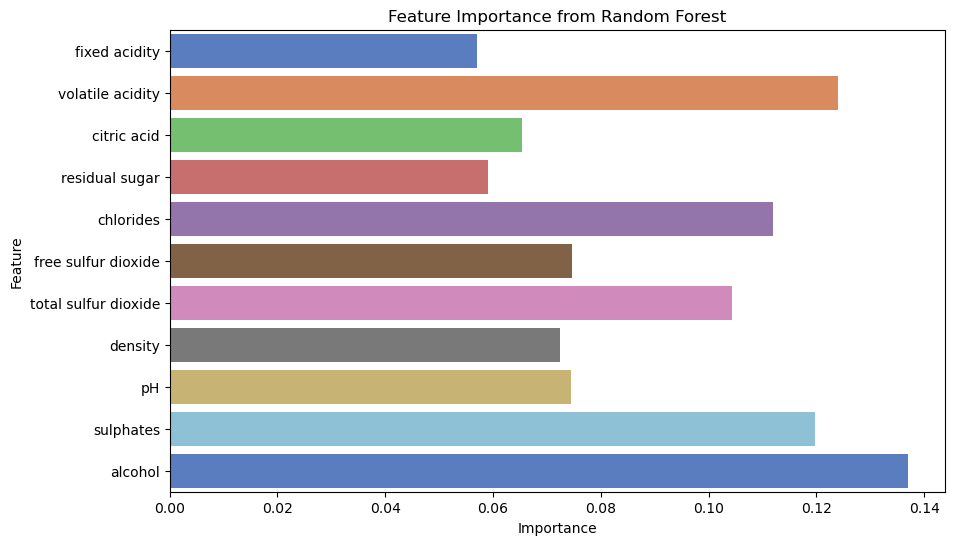

Model saved as 'best_wine_quality_model.pkl'.


In [22]:
# Feature Importance (from Random Forest)
feature_importance = rf.fit(X_train, y_train).feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=X.columns, palette='muted')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Save the best model
import joblib
joblib.dump(best_model, 'best_wine_quality_model.pkl')

print("Model saved as 'best_wine_quality_model.pkl'.")
